In [1]:
using Arrhenius
using ForwardDiff
using LinearAlgebra
using DiffEqSensitivity
using DifferentialEquations

using XLSX
using Random
using DataFrames
using ProgressBars
using DelimitedFiles
using Plots, Colors, Printf, Profile

## 1. Validation

### 1.1 Load Experiment Data

In [2]:
data = DataFrame(XLSX.readtable("2%Ethane.xlsx", "1452 K"))[!,1];
data = Float64.(hcat(data...))
data[:,1] = data[:,1]./1000; # convert [ms] to [s]

exp_t = data[:,1];
exp_T = data[:,2];
exp_P = data[:,3];
exp_Y = data[:,4:end];
exp_u = hcat(exp_Y, exp_T)';
exp_u = hcat(exp_u);

### 1.2 Load Cantera Results

In [3]:
cantera_data = readdlm("pyrolysis_C2H6.dat");
ct_t = cantera_data[:, 1];
ct_T = cantera_data[:, 2];
ct_Y = cantera_data[:, 3:end];
ct_u = hcat(ct_Y, ct_T)';

### 1.3 Run `Arrheniusl.jl` Simulation

In [4]:
gas = CreateSolution("../../mechanism/USCPyrolysis.yaml");
ns = gas.n_species;
nr = gas.n_reactions;

Y0 = zeros(ns);
Y0[species_index(gas, "C2H6")] = 0.015128646320725291;
Y0[species_index(gas, "AR")] = 1 - 0.015128646320725291;
T0 = 1452.0;
P = 3.32*one_atm;
u0 = vcat(Y0, T0);

In [5]:
@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

function YT2XT(YT)
    XT = deepcopy(YT)
    for i in 1:length(YT[1,:])
        T = YT[end,i]
        Y = YT[1:end-1,i]
        mean_MW = 1. / dot(Y, 1 ./ gas.MW)
        ρ_mass = P / R / T * mean_MW
        XT[1:end-1,i] = Y2X(gas, Y, mean_MW)
    end
    return XT;
end

YT2XT (generic function with 1 method)

In [6]:
# reltol=1e-3
# abstol=1e-6

reltol=1e-6
abstol=1e-9

# reltol=1e-9
# abstol=1e-12

tspan = [0.0, ct_t[end]*1.001];
prob = ODEProblem(dudt!, u0, tspan);
sol = solve(prob, TRBDF2(), reltol=reltol, abstol=abstol, saveat=ct_t);
ar_t = sol.t;
ar_y = Array(sol);
ar_u = YT2XT(ar_y);

In [87]:
max_min(y) = maximum(y, dims=2) .- minimum(y, dims=2);
yscale = max_min(exp_u);

### 1.4 Compare resutls

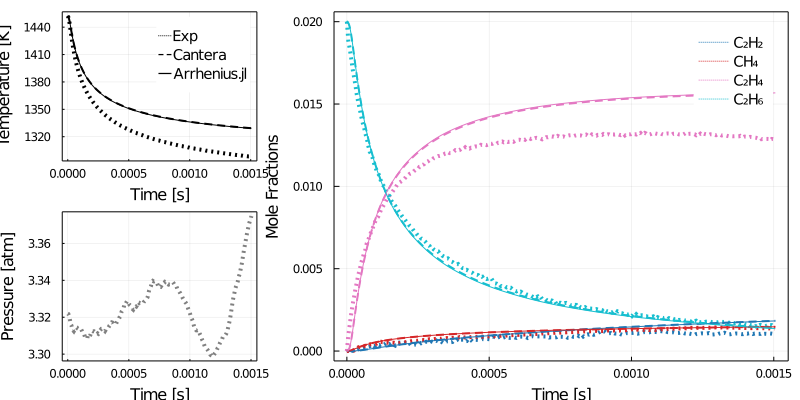

In [88]:
fs = 10;
function plot_TPX(;normalized=false)
    h1 = plot(xlabel="Time [s]", ylabel="Temperature [K]", legendfontsize=fs, foreground_color_legend=nothing)
    plot!(exp_t, exp_u[end,:], line=(4,:dot),  lc=:black, label="Exp")
    plot!( ct_t,  ct_u[end,:], line=(2,:dash), lc=:black, label="Cantera")
    plot!( ar_t,  ar_u[end,:], line=(1,:solid),lc=:black, label="Arrhenius.jl")

    h2 = plot(xlabel="Time [s]", ylabel="Pressure [atm]", legend=false)
    plot!(exp_t, exp_P, line=(4,:dot), lc=:gray)
    
    if normalized
        scale = max.(maximum(abs.(exp_u), dims=2), 1e-16)
        idx = [species_index(gas, "C2H2"), species_index(gas, "CH4"), species_index(gas, "C2H4"), species_index(gas, "C2H6"), ns+1]
        h3 = plot(xlabel="Time [s]", ylabel="Normalized Mole Fractions", palette=palette(:tab10, 5),
                legendfontsize=fs, foreground_color_legend=nothing)
        plot!(exp_t, (exp_u[:,  :]./scale)', line=(4,:dot),  label=["C₂H₂" "CH₄" "C₂H₄" "C₂H₆" "T"])
        plot!( ct_t, ( ct_u[idx,:]./scale)', line=(2,:dash), label=["" "" "" ""])
        plot!( ar_t, ( ar_u[idx,:]./scale)', line=(1,:solid),label=["" "" "" ""])
    else
        idx = [species_index(gas, "C2H2"), species_index(gas, "CH4"), species_index(gas, "C2H4"), species_index(gas, "C2H6")]
        h3 = plot(xlabel="Time [s]", ylabel="Mole Fractions", palette=palette(:tab10, 4),
                legendfontsize=fs, foreground_color_legend=nothing)
        plot!(exp_t, exp_u[1:4,:]', line=(4,:dot),  label=["C₂H₂" "CH₄" "C₂H₄" "C₂H₆"])
        plot!( ct_t,  ct_u[idx,:]', line=(2,:dash), label=["" "" "" ""])
        plot!( ar_t,  ar_u[idx,:]', line=(1,:solid),label=["" "" "" ""])
    end
    
    h = plot(h1, h2, h3, layout=@layout[grid(2,1) a{0.7w}], size=(800,400), framestyle=:box)
    display(h)
    sleep(1e-9)
end

plot_TPX()

In [89]:
@show "Average Pressure:" sum(data[3])/length(data[3]);

"Average Pressure:" = "Average Pressure:"
sum(data[3]) / length(data[3]) = 1.0e-5


## 2. Optimization

In [250]:
using Flux
using Flux: crossentropy
using Flux.Losses: mae
using Flux.Optimise: update!
using LatinHypercubeSampling
using Statistics
using DiffEqFlux

In [251]:
# settings
solver = TRBDF2();

datasize = length(exp_t);
tsteps = exp_t;
tspan = [0.0, tsteps[end]*1.001];

rng = MersenneTwister(0x7777777);
p_true = zeros(nr);
p_pred = 0.1*(2*rand(rng, nr).-1);
p_init = deepcopy(p_pred);
y_true = deepcopy(exp_u);

grad_max = 10 ^ (1);

In [252]:
# ODE function
@inbounds function dudtp!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    
    qdot = wdot_func(gas.reaction, T, C, S0, h_mole, get_qdot = true)
    wdot = gas.reaction.vk * (qdot .* exp.(p))
    
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudtp! (generic function with 1 method)

In [271]:
prob = ODEProblem(dudtp!, u0, tspan);

idx_exp = 1:5;
idx_ode = [species_index(gas, "C2H2"), species_index(gas, "CH4"), species_index(gas, "C2H4"), species_index(gas, "C2H6"), ns+1]

# Regularization of parameters
vecnorm(x) = sum(abs2,x)./length(x)
vecnorm(p_init-p_true)

0.0034736697287824536

In [272]:
sensealg = ForwardDiffSensitivity()
function predict_ode(u0, p; sample = datasize)
    _prob = remake(prob, u0=u0, p=p, tspan=[0, tsteps[sample]])
    sol = solve(_prob, solver, saveat=tsteps[1:sample], sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false)
    pred = Array(sol)
    if sol.retcode == :Success
        nothing
    else
        println("ode solver failed")
    end
    return pred
end

function loss_ode(p; start=1, sample = datasize)
    y_pred = YT2XT(predict_ode(u0, p; sample))
    loss = mae(
            (y_true[idx_exp,start:sample]./yscale[idx_exp])',
            (y_pred[idx_ode,start:sample]./yscale[idx_exp])'
        ) + vecnorm(p-p_init)/100
    return loss
end

loss_ode(p_init)

0.09987112127949609

### 2.2 Training by Datasets

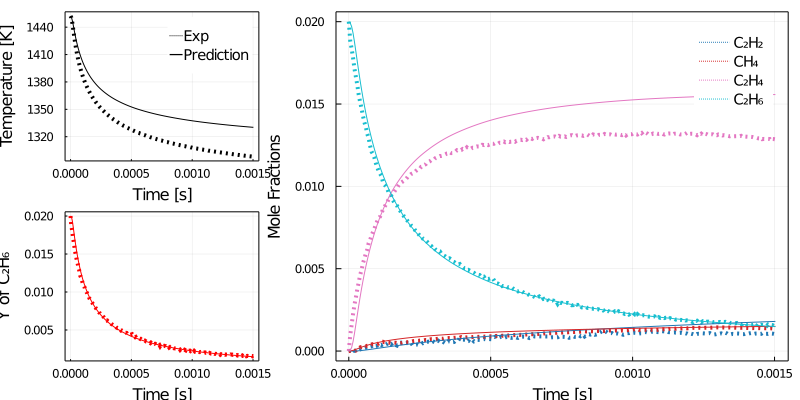

In [273]:
fs = 10;
function valid(tsteps, y_true, y_pred; normalized=false)
    IJulia.clear_output(true)
    
    h1 = plot(xlabel="Time [s]", ylabel="Temperature [K]", legendfontsize=fs, foreground_color_legend=nothing)
    plot!(tsteps, y_true[end,:], line=(4,:dot),   lc=:black, label="Exp")
    plot!(tsteps, y_pred[end,:], line=(1,:solid), lc=:black, label="Prediction")

    h2 = plot(xlabel="Time [s]", ylabel="Y of C₂H₆", legend=false)
    plot!(tsteps, y_true[end-1,:], line=(4,:dot),   lc=:red, label="Exp")
    plot!(tsteps, y_pred[species_index(gas,"C2H6"),:], line=(1,:solid), lc=:red, label="Prediction")
    
    if normalized
        scale = max.(maximum(abs.(y_true), dims=2), 1e-16)
        idx = [species_index(gas, "C2H2"), species_index(gas, "CH4"), species_index(gas, "C2H4"), species_index(gas, "C2H6"), ns+1]
        h3 = plot(xlabel="Time [s]", ylabel="Normalized Mole Fractions", palette=palette(:tab10, length(scale)),
                legendfontsize=fs, foreground_color_legend=nothing)
        plot!(tsteps, (y_true./scale)', line=(4,:dot),   label=["C₂H₂" "CH₄" "C₂H₄" "C₂H₆" "T"])
        plot!(tsteps, (y_pred[idx,:]./scale)', line=(1,:solid), label=["" "" "" "" ""])
    else
        idx = [species_index(gas, "C2H2"), species_index(gas, "CH4"), species_index(gas, "C2H4"), species_index(gas, "C2H6")]
        h3 = plot(xlabel="Time [s]", ylabel="Mole Fractions", palette=palette(:tab10, 4),
                legendfontsize=fs, foreground_color_legend=nothing)
        plot!(tsteps, y_true[1:4,:]', line=(4,:dot),   label=["C₂H₂" "CH₄" "C₂H₄" "C₂H₆"])
        plot!(tsteps, y_pred[idx,:]', line=(1,:solid), label=["" "" "" ""])
    end
    
    h = plot(h1, h2, h3, layout=@layout[grid(2,1) a{0.7w}], size=(800,400), framestyle=:box)
    display(h)
    sleep(1e-9)
end

y_pred = YT2XT(predict_ode(u0, p_init))
valid(tsteps, y_true, y_pred)

In [274]:
losses_y_train = Vector{Float64}();
losses_y_valid = Vector{Float64}();
history_p_pred = Vector{Array{Float64}}();
push!(history_p_pred, p_init);

In [275]:
function train(opt; n_epoch=10, start=1, batchsize=50, reltol=1e-6, abstol=1e-9)
    epochs = ProgressBar(1:n_epoch);
    for epoch in epochs
        # update parameters
        global p_pred

        sample = rand(batchsize:datasize)
        grad = ForwardDiff.gradient(
                    x -> loss_ode(x; start, sample),
                    p_pred)
        grad_norm = norm(grad, 2)
        if grad_norm > grad_max
            grad = grad ./ grad_norm .* grad_max
        end
        update!(opt, p_pred, grad)

        loss_y_train = loss_ode(p_pred; start, sample);
        push!(losses_y_train, loss_y_train)
        push!(history_p_pred, p_pred)
        
        # show results
        if epoch%5==0
            y_pred = YT2XT(predict_ode(u0, p_pred))
            valid(tsteps, y_true, y_pred)
        end
        set_description(epochs, string(@sprintf("Loss ytrain %.3e gnorm %.3e",
                    loss_y_train, mean(grad_norm))))
    end
end

train (generic function with 1 method)

In [276]:
p_pred = deepcopy(p_init)
loss_i = [mae(y_true[i,:]./yscale[i],y_pred[index[i],:]./yscale[i]) for i in 1:5]'

1×5 Adjoint{Float64,Array{Float64,1}}:
 0.257448  0.0957789  0.125262  0.00715705  0.167194

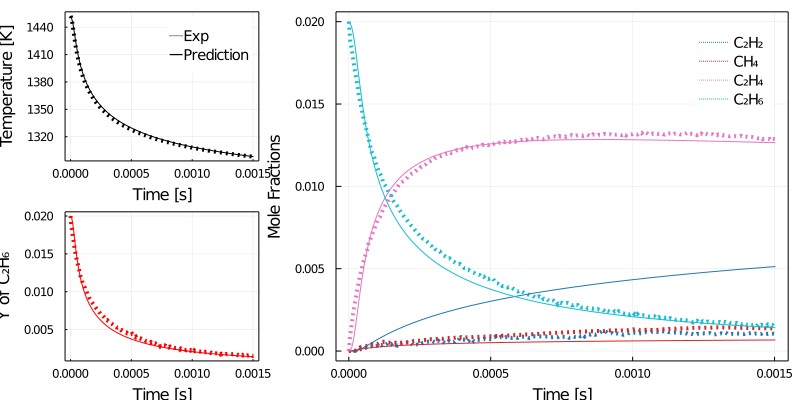

Loss ytrain 1.958e-02 gnorm 6.901e-03 100.0%┣██┫ 100/100 [00:40<00:00, 2.5 it/s]
Loss ytrain 1.958e-02 gnorm 6.901e-03 100.0%┣██┫ 100/100 [00:40<00:00, 2.5 it/s]



In [279]:
idx_exp = [3, 4, 5];
idx_ode = [species_index(gas, "C2H4"), species_index(gas, "C2H6"), ns+1]

opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=datasize, reltol=1e-6, abstol=1e-9)

In [280]:
# idx_exp = 1:5;
# idx_ode = [species_index(gas, "C2H2"), species_index(gas, "CH4"), species_index(gas, "C2H4"), species_index(gas, "C2H6"), ns+1]

# opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
# train(opt; n_epoch=100, batchsize=datasize, reltol=1e-6, abstol=1e-9)

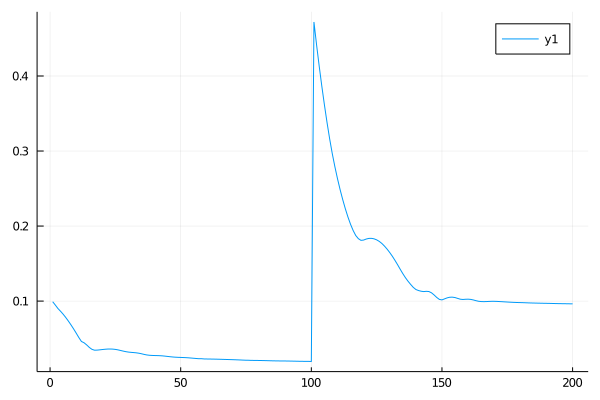

In [261]:
plot(losses_y_train)

In [262]:
y_true

5×301 Array{Float64,2}:
    0.0      1.3549e-5      3.0611e-6  …     0.0010448     0.00102
    0.0      2.4126e-6      8.074e-7         0.0013725     0.0013728
    0.0      0.00096129     0.0015904        0.012872      0.012851
    0.02     0.018849       0.018363         0.0015264     0.0015513
 1452.2   1450.9         1448.4           1298.2        1298.1

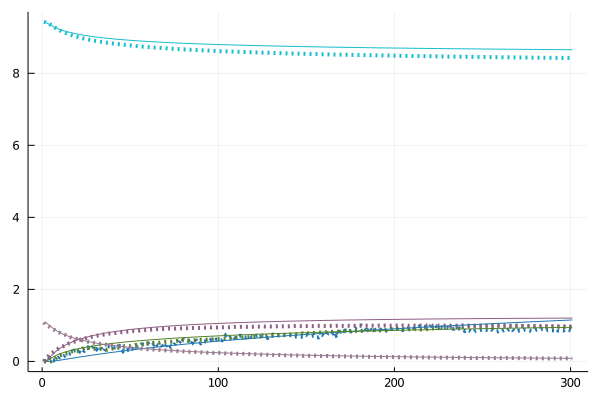

(loss_init, loss_pred) = (0.024081675912763337, 0.010642084526444464)


In [263]:
start = 150
y_pred = YT2XT(predict_ode(u0, p_init))
loss_init = Flux.Losses.huber_loss(
    (y_true[idx_exp,start:end]./yscale[idx_exp]),
    (y_pred[idx_ode,start:end]./yscale[idx_exp])
    ) #+ vecnorm(p-p_init)/100

y_pred = YT2XT(predict_ode(u0, p_pred))
loss_pred = Flux.Losses.huber_loss(
    (y_true[idx_exp,start:end]./yscale[idx_exp]),
    (y_pred[idx_ode,start:end]./yscale[idx_exp])
    ) #+ vecnorm(p-p_init)/100

h = plot(palette=palette(:tab10,length(idx_exp)))
plot!((y_true[idx_exp,:]./yscale[idx_exp])', line=(4,:dot), label="")
plot!((y_pred[idx_ode,:]./yscale[idx_exp])', line=(1,:solid), label="")
display(h)

@show loss_init, loss_pred;

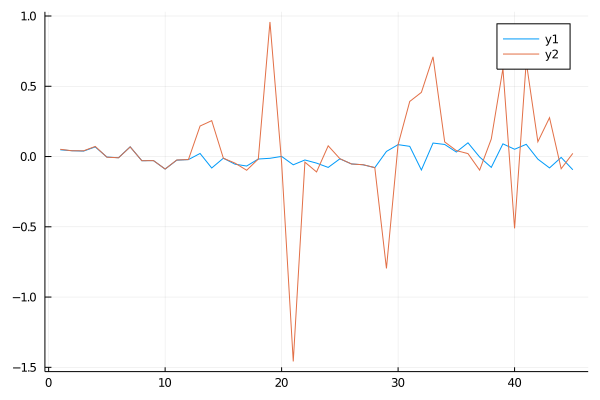

In [270]:
plot(p_init)
plot!(p_pred)